# MVO for multiple Asset Classes

## Few helper functions

In [262]:
import scipy.optimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def port_mean(W, R):
    return sum(R * W)

def port_var(W, C):
    return np.dot(np.dot(W, C), W)

def port_mean_var(W, R, C):
    return port_mean(W, R), port_var(W, C)

def normalize_array(arr):
    min_value = np.min(arr)
    if min_value < 0: # Ensure all values are positive by adding a constant to all elements
        arr = arr - min_value # Add a small constant to avoid zero values
    arr_sum = np.sum(arr) # Normalize the array so that the sum is 1
    normalized_arr = arr / arr_sum
    return normalized_arr

def solve_weights(R, C, rf):
    def fitness(W, R, C, rf):
        mean, var = port_mean_var(W, R, C)
        util = (mean - rf) / np.sqrt(var)  # utility = sharpe ratio
        return 1 / (util + 1e-9)  # maximize the utility, minimize its inverse value
    
    n = len(R)
    W = normalize_array(R)
    b_ = [(0., 1.) for _ in range(n)]  # weights for boundaries between 0%..100%. No leverage, no shorting
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.},  # Sum of weights must be 100%
          {'type': 'ineq', 'fun': lambda W: np.dot(W, R) - rf})  # Expected return greater than risk-free rate

    def fitness_wrapper(W):
        return fitness(W, R, C, rf)  

    optimized = scipy.optimize.minimize(fitness_wrapper, W, method='SLSQP', 
                                        constraints=c_, bounds=b_, 
                                        options={'maxiter': 1e9, 'ftol': 5})
    if not optimized.success: 
        # display("SUM_R: ", np.sum(R))
        # display("W: ", W)
        # display("R: ", R)
        # display("rf: ", rf)
        # display("Vol: ", np.sqrt(np.diagonal(C)))
        # display("===========================================================")
        mean, var = port_mean_var(W, R, C)
        return W, 1, mean, var 
        # if not optimized.success: raise BaseException(optimized.message)
    
    mean, var = port_mean_var(optimized.x, R, C)
    return optimized.x, 0, mean, var

## Load Historical Prices

In [263]:
def load_data():
    """
    Load data from a CSV file and return a list of symbols and their corresponding prices.

    Returns:
    symbols (list): A list of symbols.
    prices_out (list): A list of lists containing the prices for each symbol.
    """
    symbols = ['IMA-S', 'IMA-B', 'IRF-M', 'IHFA', 'Ibovespa', 'S&P 500']
    n = len(symbols)
    prices_out = []
    dataframe = pd.read_csv('G:/My Drive/Poli-USP/TCC/Codes/MVO/AA_indexes.csv', 
                                index_col=['Data'],
                                sep=';', decimal=',', thousands=" ",
                                parse_dates=['Data'])
    for s in symbols:
        prices = list(dataframe.loc['2014-01-01':'2023-12-31', s])
        prices_out.append(prices)
    dates = dataframe.loc['2014-01-01':'2023-12-31'].index
    return dates, symbols, prices_out

dates, names, prices = load_data()

## Estimate assets hitorical return and covariances

In [264]:
def assets_historical_returns_and_covariances(prices):
    prices = np.matrix(prices) 
    
    # create matrix of historical returns
    rows, cols = prices.shape # each row is an asset
    returns = np.empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1 # create a matrix of returns
    
    # calculate returns
    expreturns = np.array([]) 
    expreturns = np.append(expreturns, (prices[:, -1] / prices[:, 0])) - 1 # Annualize returns

    # expreturns = np.append(expreturns, np.mean(returns, axis=1)) # daily expected return for each asset
    # expreturns = (1 + expreturns) ** (cols/10) - 1  # Annualize returns
    
    # calculate covariances
    covars = np.cov(returns)
    # covars = covars * cols/10  # Annualize covariances
    
    return expreturns, covars

def percentage(x): # where x is an array with a list or a matrix
    if len(x.shape) == 2:
        x = np.round(np.multiply(x, 100), 2)
        perc_x = np.empty(x.shape, dtype=object)
        for r in range(x.shape[0]):
            for c in range(x.shape[1]):
                perc_x[r, c] = str(x[r, c]) + '%'
    else:
        perc_x = np.round(np.multiply(x, 100), 2)
        perc_x = [str(value) + '%' for value in perc_x]
    return perc_x

# R, C = assets_historical_returns_and_covariances(prices)
# rf = 0.0928  # Risk-free rate
# vol = np.sqrt(np.diagonal(C))
# display(pd.DataFrame({'Return': percentage(R)}, index=names).T)
# display(pd.DataFrame({'Volatility': percentage(vol)}, index=names).T)
# display(pd.DataFrame(percentage(C), index=names, columns=names))
# res1 = optimize_frontier(R, C, rf)
# display_assets(names, R, C, color='blue')
# plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.show()
# display(pd.DataFrame({'Weight': res1.W}, index=names).T)

## Mean-Variance Optimization

In [265]:
# Get the risk-free rate for a desired window
def risk_free_IMA_B(IMA_B, i, window_size=50):
    rf = IMA_B[i+window_size-1] / IMA_B[i] - 1
    return rf

window_size = 50
reduction = 0
errors = 0
rows = len(prices[0])-window_size-reduction; cols = len(prices)
weights = np.empty([rows, cols])
mean = np.empty([rows]); variance = np.empty([rows])

# Get the asset allocation for each window
for i in tqdm(range(rows)):
    rf = risk_free_IMA_B(prices[0], i, window_size)
    truncated_prices = [index[i:i+window_size] for index in prices]
    R, C = assets_historical_returns_and_covariances(truncated_prices)
    weights[i], err, mean[i], variance[i] = solve_weights(R, C, rf)
    errors += err 

print("Errors: ", errors)
print("# of days: ", rows)

  0%|          | 0/2458 [00:00<?, ?it/s]

Errors:  0
# of days:  2458


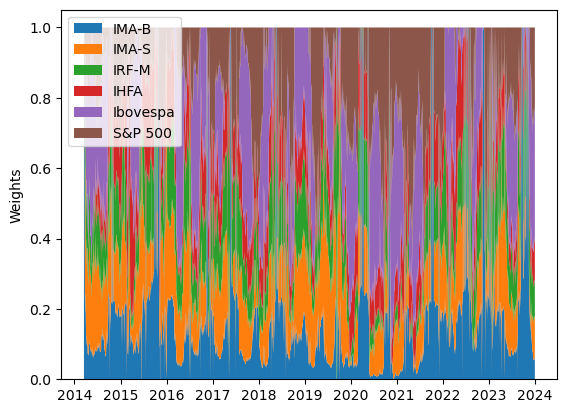

In [266]:
# Enable interactive plotting
%matplotlib inline

# Assuming your data is in the form of a 2D list with each inner list representing a different line
data = np.array(weights)
x = dates[50+reduction:]
# x = np.arange(rows)  # X-axis values (assume equally spaced for simplicity)

# Plotting the stacked area plot
fig, ax = plt.subplots()
ax.stackplot(x, data.T, labels=['IMA-B', 'IMA-S', 'IRF-M', 'IHFA', 'Ibovespa', 'S&P 500'])

# Add legend, titles, and labels
ax.legend(loc='upper left')
plt.ylabel('Weights')

# Show the plot
plt.show()

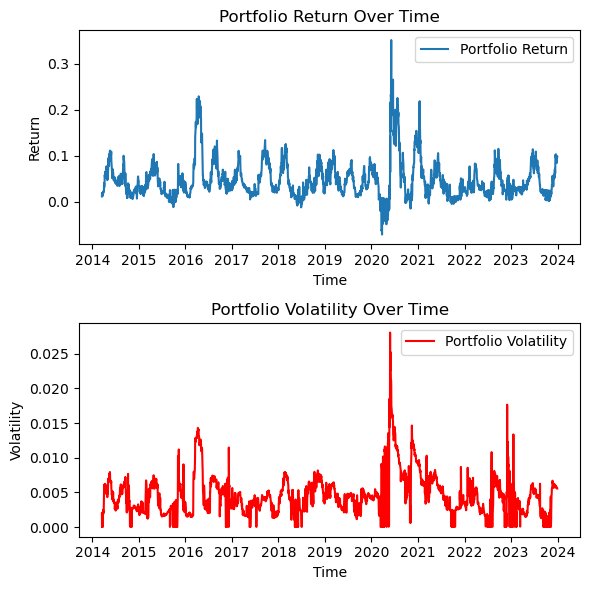

In [267]:
# Creating subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plotting port_return on the first subplot
axs[0].plot(x, mean, label='Portfolio Return')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Return')
axs[0].set_title('Portfolio Return Over Time')
axs[0].legend()

# Plotting port_vol on the second subplot
axs[1].plot(x, np.sqrt(variance), label='Portfolio Volatility', color='red')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Volatility')
axs[1].set_title('Portfolio Volatility Over Time')
axs[1].legend()

plt.tight_layout()
plt.show()

(6, 2458)


ValueError: x and y must have same first dimension, but have shapes (2452,) and (6, 6)

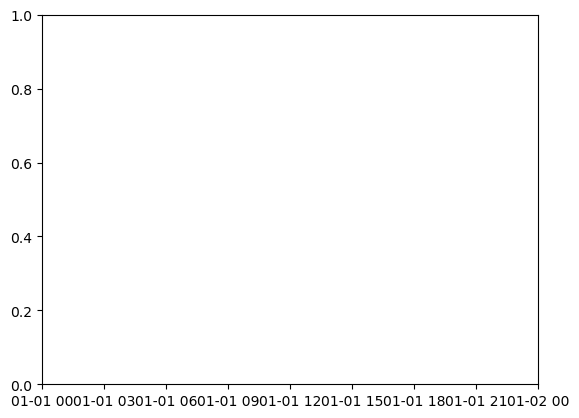

In [280]:
def portfolio_return(prices, weights):
    prices = np.matrix(prices) 
    
    # create matrix of historical returns
    rows, cols = prices.shape # each row is an asset
    returns = np.empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1 # create a matrix of returns
    return np.dot(prices, weights)

trimmed_prices = [lst[:cols-window_size-reduction-6] for lst in prices]
trimmed_prices = np.array(trimmed_prices)
print(trimmed_prices.shape)
historical_return = portfolio_return(trimmed_prices, weights)

# # Plotting historical returns
# fig, ax = plt.subplots()
# ax.plot(dates[window_size+reduction+6:], historical_return)
# ax.set_xlabel('Time')
# ax.set_ylabel('Historical Return')
# ax.set_title('Historical Returns Over Time')

# plt.show()